In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

import numpy as np
import jax
import jax.numpy as jnp
from temgym_core.components import Detector, Lens
from temgym_core.gaussian import make_gaussian_image, GaussianRay, evaluate_gaussian_input_image
from temgym_core.source import ParallelBeam
from temgym_core.ray import Ray
from temgym_core.utils import fibonacci_spiral, custom_jacobian_matrix
from temgym_core.run import run_to_end

%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
scale = 1e6  # scale to microns

aperture_window_width = 1e-6 * scale  # 1 um aperture window width
num_aper_pixels = 100
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 2.5e-7 * scale  # 500 nm aperture radius

num_beams = int(1e6)
r1x, r1y = fibonacci_spiral(nb_samples=num_beams, radius=aperture_radius, alpha=0)

wavelength = 2e-12 * scale  # 2 pm wavelength
k = 2 * np.pi / wavelength
wo = 1e-9 * scale

#area of aperture
aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (wo ** 2 * num_beams * np.pi)

In [3]:

# Gaussian Beam Input
xs = r1x
ys = r1y
dxs = np.zeros(num_beams)
dys = np.zeros(num_beams)
zs = np.zeros(num_beams)
pathlengths = np.zeros(num_beams)
ones = np.ones(num_beams)
amplitudes = np.ones(num_beams) * scale_factor
radii_of_curv = np.full((num_beams, 2), np.inf)
theta = np.zeros(num_beams)
wavelength = wavelength
wavelengths = np.full((num_beams,), wavelength)
wo = wo
waist_xy = np.full((num_beams, 2), wo)

rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=zs,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,  # 1x2 per Gaussian Ray
    radii_of_curv=radii_of_curv,  # 1x2 per Gaussian Ray
    wavelength=wavelengths, 
    theta=theta,
)

input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)


In [4]:
# Warm up JIT by evaluating a single-ray batch
rays_single = GaussianRay(
    x=xs[:1],
    y=ys[:1],
    dx=dxs[:1],
    dy=dys[:1],
    z=zs[:1],
    pathlength=pathlengths[:1],
    _one=ones[:1],
    amplitude=amplitudes[:1],
    waist_xy=waist_xy[:1],
    radii_of_curv=radii_of_curv[:1],
    wavelength=wavelengths[:1],
    theta=theta[:1],
)
_ = evaluate_gaussian_input_image(rays_single, input_aperture_grid, batch_size=1)


In [5]:
# Full evaluation
aperture_image = evaluate_gaussian_input_image(rays, input_aperture_grid, batch_size=1000)

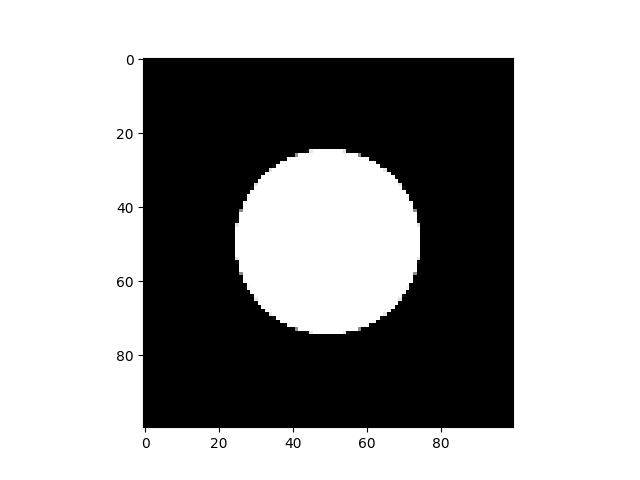

In [6]:
plt.figure()
plt.imshow(jnp.abs(aperture_image), cmap='gray')

In [7]:
M1 = -100
F1 = 2.5e-3 * scale
M2 = -400
F2 = 1e-2 * scale

defocus = 1e-6 * scale
L1_z1 = F1 * (1/M1 - 1)
L1_z2 = F1 * (1 - M1)
L2_z1 = F2 * (1/M2 - 1)
L2_z2 = F2 * (1 - M2)

input_beam = ParallelBeam(z=0.0 - defocus, radius=aperture_radius)
Lens1 = Lens(focal_length=F1, z=abs(L1_z1))
Lens2 = Lens(focal_length=F2, z=abs(L1_z1) + abs(L1_z2) + abs(L2_z1))
detector = Detector(z=abs(L1_z1) + abs(L1_z2) + abs(L2_z1) + abs(L2_z2), pixel_size=(55e-6 * 4 * scale, 55e-6 * 4 * scale), shape=(128, 128))
model = [
    input_beam,
    Lens1,
    Lens2,
    detector,
]

central_ray = Ray(x=0.0, y=0.0, dx=0.0, dy=0.0, z=input_beam.z, pathlength=0.0, _one=1.0)
out_ray = run_to_end(central_ray, model)

ABCD = jax.jacobian(lambda r: run_to_end(r, model))(central_ray)
ABCD = custom_jacobian_matrix(ABCD)
print(ABCD)

[[4.0000e+04 0.0000e+00 4.0000e+04 0.0000e+00 0.0000e+00]
 [0.0000e+00 4.0000e+04 0.0000e+00 4.0000e+04 0.0000e+00]
 [1.0001e-02 0.0000e+00 1.0026e-02 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.0001e-02 0.0000e+00 1.0026e-02 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]]


In [8]:
rays = GaussianRay(
    x=xs, 
    y=ys, 
    dx=dxs,
    dy=dys, 
    z=jnp.ones_like(xs) * input_beam.z,
    pathlength=pathlengths, 
    _one=ones, 
    amplitude=amplitudes, 
    waist_xy=waist_xy,
    radii_of_curv=radii_of_curv,
    wavelength=wavelengths, 
    theta=theta,
)
det_image = make_gaussian_image(rays, model, batch_size=1000)

In [9]:
central_rays = rays.to_ray()
out_rays = run_to_end(central_rays, model)

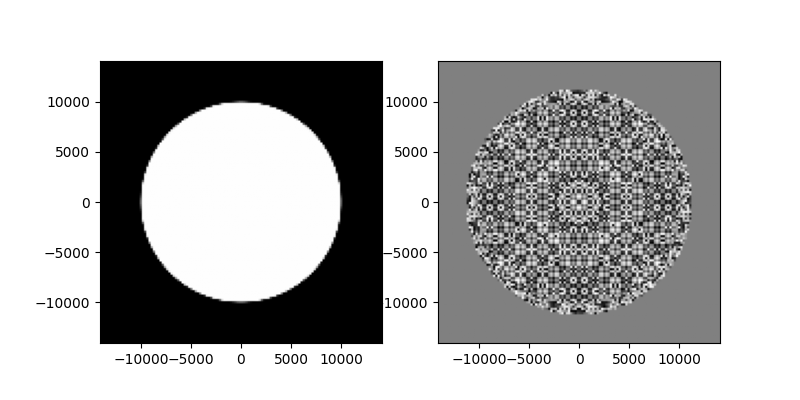

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
img = np.abs(det_image)
ang = np.angle(det_image)

ax[0].plot(out_rays.x, out_rays.y, 'g.', markersize=1, alpha=0.001)
ax[0].imshow(img, cmap="gray", extent=[-detector.pixel_size[0]*detector.shape[0]/2, detector.pixel_size[0]*detector.shape[0]/2, -detector.pixel_size[1]*detector.shape[1]/2, detector.pixel_size[1]*detector.shape[1]/2])
ax[1].imshow(ang, cmap="gray", extent=[-detector.pixel_size[0]*detector.shape[0]/2, detector.pixel_size[0]*detector.shape[0]/2, -detector.pixel_size[1]*detector.shape[1]/2, detector.pixel_size[1]*detector.shape[1]/2])

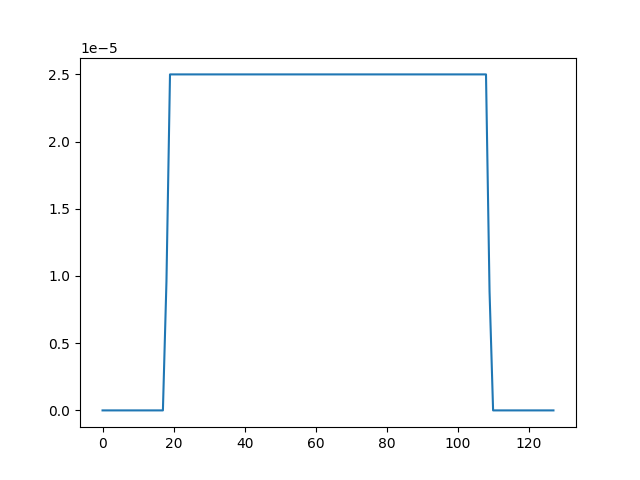

: 

In [ ]:
plt.figure()
plt.plot(img[detector.shape[0]//2, :])